--- Section 1: Infinite-Horizon Discrete LQR ---
Example: Infinite-Horizon LQR Simulation
Optimal LQR Gain (Infinite Horizon) K = [[1.15331367 0.33378917]]
Simulation stopped after 48 steps.


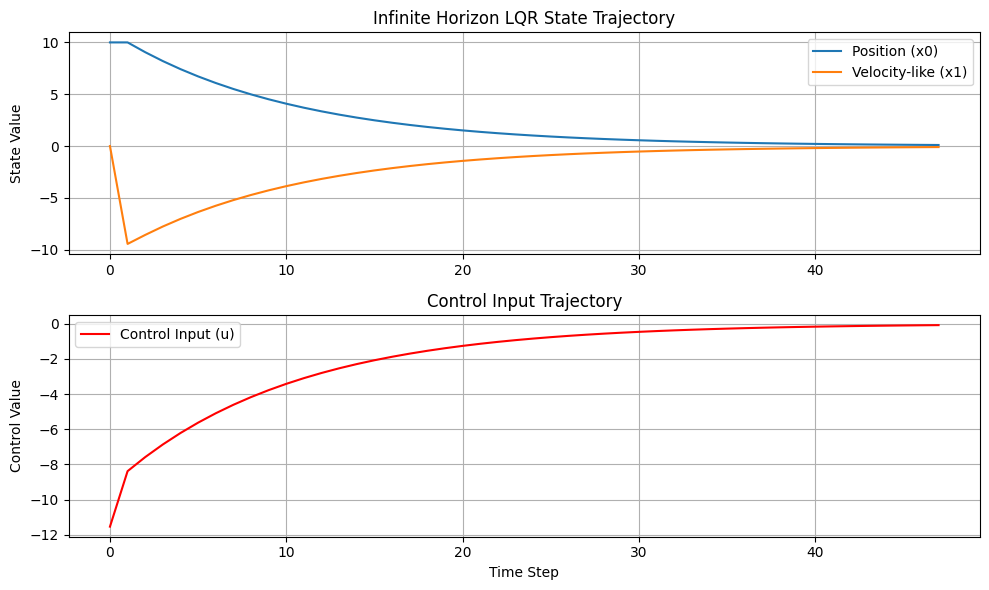


--- Section 2: Finite-Horizon Discrete LQR ---

Example: Finite-Horizon LQR Simulation

Iteration = 0
Current State = [10.  0.]
Desired State = [0. 0.]
State Error Magnitude = 10.0000
Control Input = [-9.30425585]

Iteration = 1
Current State = [10.        -7.6176804]
Desired State = [0. 0.]
State Error Magnitude = 12.5710
Control Input = [-6.9317988]

Iteration = 2
Current State = [ 9.23823196 -7.05612804]
Desired State = [0. 0.]
State Error Magnitude = 11.6247
Control Input = [-6.39792068]

Iteration = 3
Current State = [ 8.53261916 -6.51723343]
Desired State = [0. 0.]
State Error Magnitude = 10.7368
Control Input = [-5.90923428]

Iteration = 4
Current State = [ 7.88089581 -6.01944583]
Desired State = [0. 0.]
State Error Magnitude = 9.9168
Control Input = [-5.45788562]

Iteration = 5
Current State = [ 7.27895123 -5.55967921]
Desired State = [0. 0.]
State Error Magnitude = 9.1593
Control Input = [-5.04101109]

Iteration = 6
Current State = [ 6.72298331 -5.13502967]
Desired State = [0

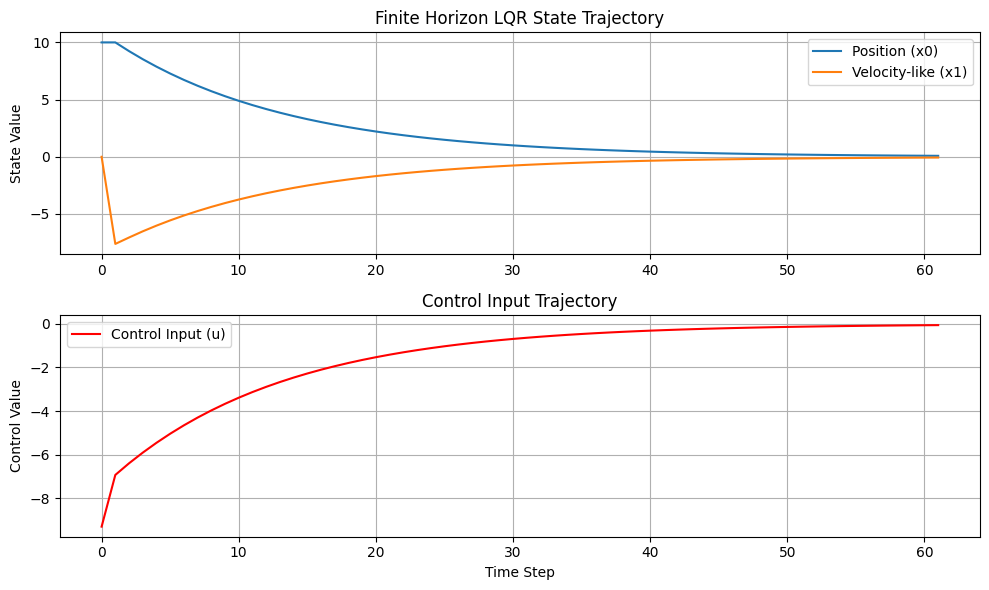


--- Section 3: EKF ---


In [2]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
# from plot_ult import * # Assuming this is a custom plotting library, commented out

# =============================================================================
# Section 1: Infinite-Horizon Discrete LQR Solver
# (Based on fixing the user's 'lqg' function logic)
# =============================================================================
print("--- Section 1: Infinite-Horizon Discrete LQR ---")

def solve_discrete_lqr_infinite_horizon(A, B, Q, R):
    """
    Solves the discrete-time algebraic Riccati equation (DARE)
    for infinite-horizon LQR.

    min J = sum(x_k^T Q x_k + u_k^T R u_k)
    s.t. x_{k+1} = A x_k + B u_k

    Args:
        A (np.ndarray): State transition matrix (n x n)
        B (np.ndarray): Control input matrix (n x m)
        Q (np.ndarray): State cost matrix (n x n)
        R (np.ndarray): Control cost matrix (m x m)

    Returns:
        K (np.ndarray): Optimal feedback gain matrix (m x n), such that u = -K x
        P (np.ndarray): Solution to the DARE (n x n)
    """
    # Solve the discrete-time algebraic Riccati equation
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # Calculate the optimal feedback gain K
    # K = (R + B^T P B)^(-1) * (B^T P A)
    K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

    return K, P

def dynamic_sim(x, u, A, B):
    """Simple discrete-time linear dynamics update."""
    x_next = A @ x + B @ u
    return x_next

# --- Example Usage for Infinite-Horizon LQR ---
print("Example: Infinite-Horizon LQR Simulation")
dt_lqg = 0.1
tau_lqg = 0.5
tau_a_lqg = np.exp(-dt_lqg / tau_lqg)

# System Matrices (Discrete Time)
A_lqg = np.array([[1., dt_lqg],
                  [0., 1 - tau_a_lqg]]) # State: [position; velocity_like_term]
B_lqg = np.array([[0.],
                  [tau_a_lqg]])       # Control: u (scalar)
n_states_lqg = A_lqg.shape[0]
m_controls_lqg = B_lqg.shape[1]

# Cost Matrices
Q_lqg = np.diag([1., 1.]) # Penalize state error (pos and vel)
R_lqg = np.array([[0.01]]) # Penalize control effort (scalar u)

# Solve for the optimal gain
K_lqg, P_lqg = solve_discrete_lqr_infinite_horizon(A_lqg, B_lqg, Q_lqg, R_lqg)
print(f"Optimal LQR Gain (Infinite Horizon) K = {K_lqg}")

# Simulation
x_lqg = np.array([[10.], [0.]]) # Initial state: pos=10, vel=0
xs_lqg, us_lqg = [], []
t_lqg = 0
max_steps_lqg = 100 # Limit simulation steps

while abs(x_lqg[0,0]) > 0.1 and t_lqg < max_steps_lqg: # Stop when position is close to 0
    # Calculate control input: u = -K * x
    u_lqg = -K_lqg @ x_lqg
    # Store values BEFORE updating state
    xs_lqg.append(x_lqg.copy()) # Store copy
    us_lqg.append(u_lqg.copy()) # Store copy
    # Update state
    x_lqg = dynamic_sim(x_lqg, u_lqg, A_lqg, B_lqg)
    t_lqg += 1

print(f"Simulation stopped after {t_lqg} steps.")

# Plotting LQR results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot([t[0, 0] for t in xs_lqg], label='Position (x0)')
plt.plot([t[1, 0] for t in xs_lqg], label='Velocity-like (x1)')
plt.title('Infinite Horizon LQR State Trajectory')
plt.ylabel('State Value')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot([u[0, 0] for u in us_lqg], label='Control Input (u)', color='r')
plt.title('Control Input Trajectory')
plt.xlabel('Time Step')
plt.ylabel('Control Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# =============================================================================
# Section 2: Finite-Horizon Discrete LQR Solver
# (Based on fixing the user's 'lqr' function logic)
# =============================================================================
print("\n--- Section 2: Finite-Horizon Discrete LQR ---")

# Optional Variables for clipping (can be adjusted)
max_linear_velocity = 20.0 # Increased limit based on potential control values
max_angular_velocity = 15.0 # Radians per second (Not used if B is 2x1)


def state_space_model_lqr(A, state_t_minus_1, B, control_input_t_minus_1):
    """Applies dynamics and clips control input."""
    # Clip control input (assuming scalar input here based on corrected B)
    # If control is vector, adjust indexing and limits
    u_clipped = np.clip(control_input_t_minus_1,
                        -max_linear_velocity, # Using linear velocity limit for scalar u
                        max_linear_velocity)

    # Prediction
    state_estimate_t = (A @ state_t_minus_1) + (B @ u_clipped)

    return state_estimate_t


def solve_discrete_lqr_finite_horizon(actual_state_x, desired_state_xf, Q, R, A, B, N):
    """
    Discrete-time linear quadratic regulator for a finite horizon N.

    Args:
        actual_state_x (np.ndarray): Current state (n x 1)
        desired_state_xf (np.ndarray): Desired final state (n x 1)
        Q (np.ndarray): State cost matrix (n x n)
        R (np.ndarray): Control cost matrix (m x m)
        A (np.ndarray): State transition matrix (n x n)
        B (np.ndarray): Control input matrix (n x m)
        N (int): Finite horizon length

    Returns:
        u_star (np.ndarray): Optimal control input for the *first* step (m x 1)
    """
    n_states = A.shape[0]
    m_controls = B.shape[1]

    # Ensure states are column vectors
    actual_state_x = actual_state_x.reshape(n_states, 1)
    desired_state_xf = desired_state_xf.reshape(n_states, 1)

    # We want the system to stabilize at desired_state_xf.
    # Calculate error relative to the desired final state for cost calculation
    # Note: LQR traditionally minimizes cost w.r.t origin. To stabilize at xf,
    #       we often linearize around xf or use error dynamics.
    #       Here, we calculate gain based on dynamics around origin,
    #       but apply it to the error term x - xf, which is common.
    x_error = actual_state_x - desired_state_xf

    # Solutions via dynamic programming
    P = [None] * (N + 1)
    Qf = Q # Final cost = state cost
    P[N] = Qf

    # Backward pass: Calculate P matrices
    for i in range(N, 0, -1):
        try:
            # Ensure matrices have compatible dimensions before operations
            P_next = P[i]
            term1 = A.T @ P_next @ B
            term2 = R + B.T @ P_next @ B
            term3 = B.T @ P_next @ A

            # Discrete-time Algebraic Riccati equation
            P[i-1] = Q + A.T @ P_next @ A - term1 @ np.linalg.pinv(term2) @ term3
        except np.linalg.LinAlgError:
            print(f"Warning: Matrix inversion failed at step {i}. Using previous P.")
            P[i-1] = P[i] # Fallback if inversion fails
        except Exception as e:
             print(f"Error in Riccati iteration at step {i}: {e}")
             # Handle error appropriately, e.g., return None or raise
             return None # Indicate failure


    # Forward pass simulation is not done here, we only calculate the gain sequence
    # Calculate the optimal feedback gain K for the first step (i=0)
    try:
        K_0 = -np.linalg.pinv(R + B.T @ P[1] @ B) @ B.T @ P[1] @ A
    except np.linalg.LinAlgError:
         print("Warning: Matrix inversion failed for K_0 calculation.")
         # Handle error: maybe return zero control or previous control
         K_0 = np.zeros((m_controls, n_states)) # Default to zero gain on error


    # Optimal control input for the current state x_error
    # u = K * x_error (Note: K is negative, so u = -|K|*x_error)
    u_star = K_0 @ x_error

    return u_star

# --- Example Usage for Finite-Horizon LQR ---
print("\nExample: Finite-Horizon LQR Simulation")

dt_lqr = 0.1
tau_lqr = 0.5
tau_a_lqr = np.exp(-dt_lqr / tau_lqr)

# System Matrices (Matching the LQR function's expectation)
A_lqr = np.array([[1., dt_lqr],
                  [0., 1 - tau_a_lqr]]) # State: [pos; vel_like_term]
B_lqr = np.array([[0.],
                  [tau_a_lqr]])       # Control: u (scalar)
n_states_lqr = A_lqr.shape[0]
m_controls_lqr = B_lqr.shape[1]

# Actual state (initial)
actual_state_x_lqr = np.array([[10.], [0.]]) # Start at pos=10, vel=0

# Desired state (final)
desired_state_xf_lqr = np.array([[0.], [0.]]) # Target origin

# Cost Matrices (Corrected Dimensions)
Q_lqr = np.array([[0.639, 0],  # Penalize position error
                  [0, 1.0]]) # Penalize velocity error
R_lqr = np.array([[0.01]])   # Penalize control effort (scalar u) - CORRECTED DIMENSION

# LQR Horizon
N_lqr = 50 # Finite horizon length

# Simulation Loop
max_sim_steps_lqr = 100
xs_lqr_fin, us_lqr_fin = [], []

for i in range(max_sim_steps_lqr):
    print(f'\nIteration = {i}')
    print(f'Current State = {actual_state_x_lqr.flatten()}')
    print(f'Desired State = {desired_state_xf_lqr.flatten()}')

    state_error_lqr = actual_state_x_lqr - desired_state_xf_lqr
    state_error_magnitude_lqr = np.linalg.norm(state_error_lqr)
    print(f'State Error Magnitude = {state_error_magnitude_lqr:.4f}')

    # Check for goal achievement
    if state_error_magnitude_lqr < 0.1:
        print("\nGoal Has Been Reached Successfully!")
        break

    # LQR returns the optimal control input for the current state
    optimal_control_input = solve_discrete_lqr_finite_horizon(
                                actual_state_x_lqr,
                                desired_state_xf_lqr,
                                Q_lqr, R_lqr, A_lqr, B_lqr, N_lqr)

    if optimal_control_input is None:
         print("LQR failed to compute control input. Stopping simulation.")
         break

    print(f'Control Input = {optimal_control_input.flatten()}')

    # Store values BEFORE updating state
    xs_lqr_fin.append(actual_state_x_lqr.copy()) # Store copy
    us_lqr_fin.append(optimal_control_input.copy()) # Store copy

    # Apply the optimal control to the system model to get the next state
    actual_state_x_lqr = state_space_model_lqr(A_lqr, actual_state_x_lqr, B_lqr,
                                               optimal_control_input)

else: # This else block executes if the loop completes without break
    print("\nSimulation reached maximum steps.")


# Plotting Finite Horizon LQR results
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
if xs_lqr_fin: # Check if list is not empty
    plt.plot([t[0, 0] for t in xs_lqr_fin], label='Position (x0)')
    plt.plot([t[1, 0] for t in xs_lqr_fin], label='Velocity-like (x1)')
else:
    plt.text(0.5, 0.5, 'No simulation data', horizontalalignment='center', verticalalignment='center')
plt.title('Finite Horizon LQR State Trajectory')
plt.ylabel('State Value')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
if us_lqr_fin: # Check if list is not empty
    plt.plot([u[0, 0] for u in us_lqr_fin], label='Control Input (u)', color='r')
else:
     plt.text(0.5, 0.5, 'No simulation data', horizontalalignment='center', verticalalignment='center')
plt.title('Control Input Trajectory')
plt.xlabel('Time Step')
plt.ylabel('Control Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# =============================================================================
# Section 3: EKF Function Definition
# =============================================================================
print("\n--- Section 3: EKF ---")

# Placeholder for the getB function required by EKF
def getB(yaw_angle, dt):
    """
    Placeholder function to compute the B matrix for EKF based on yaw and dt.
    Replace with your actual implementation.
    This example assumes a simple model where control affects x, y, yaw.
    Control vector might be [linear_velocity, angular_velocity].
    State vector might be [x, y, yaw].
    """
    # Example B matrix structure (adjust based on your model)
    # Assumes control_vector is [v, omega]
    B = np.array([[np.cos(yaw_angle) * dt, 0],
                  [np.sin(yaw_angle) * dt, 0],
                  [0, dt]])
    return B

# EKF System matrices (as defined in user code)
A_k_minus_1 = np.array([[1.0,  0,   0],
                        [  0,1.0,   0],
                        [  0,  0, 1.0]]) # Assumes state doesn't change without control/noise

# Process noise covariance
Q_k = np.array([[1.0,   0,   0], # User-defined, seems large? Example: 0.01 variance
                [  0, 1.0,   0],
                [  0,   0, 1.0]])

# Measurement matrix
H_k = np.array([[1.0,  0,   0], # Assumes direct measurement of x, y, yaw
                [  0,1.0,   0],
                [  0,  0, 1.0]])

# Measurement noise covariance
R_k = np.array([[1.0,   0,    0], # User-defined, seems large? Example: 0.1 variance
                [  0, 1.0,    0],
                [  0,    0, 1.0]])

# Example noise vectors (These represent specific noise instances, not covariances)
# Usually, noise is added *during* simulation, not as fixed vectors in the EKF function.
# The EKF uses the *covariance* matrices Q_k and R_k.
# process_noise_v_k_minus_1 = np.array([0.01,0.01,0.003]) # Should typically be sampled N(0, Q_k)
# sensor_noise_w_k = np.array([0.07,0.07,0.04]) # Should typically be sampled N(0, R_k)


def ekf(z_k_observation_vector, state_estimate_k_minus_1,
        control_vector_k_minus_1, P_k_minus_1, dt_ekf): # Changed dk to dt_ekf for clarity
    """
    Extended Kalman Filter update step.
    Note: Assumes process and sensor noise are zero-mean Gaussian with
          covariances Q_k and R_k respectively. The noise vectors provided
          in the original code are ignored here in favor of using the covariances.
    """
    # Ensure inputs are numpy arrays
    state_estimate_k_minus_1 = np.asarray(state_estimate_k_minus_1)
    control_vector_k_minus_1 = np.asarray(control_vector_k_minus_1)
    z_k_observation_vector = np.asarray(z_k_observation_vector)
    P_k_minus_1 = np.asarray(P_k_minus_1)

    # --- Predict ---
    # Predict state using the state-space model (linearized A, calculated B)
    # Assumes state is [x, y, yaw] and control is [v, omega]
    current_yaw = state_estimate_k_minus_1[2] # Extract yaw for B matrix calculation
    B_k_minus_1 = getB(current_yaw, dt_ekf) # Calculate B based on current state

    # State prediction (without process noise vector)
    state_estimate_k_predicted = A_k_minus_1 @ state_estimate_k_minus_1 + B_k_minus_1 @ control_vector_k_minus_1

    print(f'Predicted State Estimate Before EKF Update = {state_estimate_k_predicted}')

    # Predict the state covariance estimate
    P_k_predicted = A_k_minus_1 @ P_k_minus_1 @ A_k_minus_1.T + Q_k

    # --- Update (Correct) ---
    # Calculate the measurement residual (innovation)
    # Difference between actual measurement and predicted measurement (without sensor noise vector)
    measurement_residual_y_k = z_k_observation_vector - (H_k @ state_estimate_k_predicted)

    print(f'Observation={z_k_observation_vector}')
    print(f'Measurement Residual (Innovation) y_k = {measurement_residual_y_k}')

    # Calculate the measurement residual covariance (innovation covariance)
    S_k = H_k @ P_k_predicted @ H_k.T + R_k

    # Calculate the near-optimal Kalman gain
    try:
        K_k = P_k_predicted @ H_k.T @ np.linalg.pinv(S_k)
    except np.linalg.LinAlgError:
         print("Warning: Matrix inversion failed for Kalman Gain calculation. Using zero gain.")
         K_k = np.zeros((A_k_minus_1.shape[0], H_k.shape[0])) # Zero gain

    # Calculate updated state estimate for time k
    state_estimate_k_updated = state_estimate_k_predicted + (K_k @ measurement_residual_y_k)

    # Update the state covariance estimate for time k (using Joseph form for stability if needed)
    I_KH = np.identity(A_k_minus_1.shape[0]) - (K_k @ H_k)
    P_k_updated = I_KH @ P_k_predicted @ I_KH.T + K_k @ R_k @ K_k.T # Joseph form
    # P_k_updated = P_k_predicted - (K_k @ H_k @ P_k_predicted) # Simpler form

    print(f'State Estimate After EKF Update = {state_estimate_k_updated}')

    # Return the updated state and covariance estimates
    return state_estimate_k_updated, P_k_updated

# Example EKF usage (requires setting up initial state, P, controls, observations)
# print("\nEKF Function defined. Example usage would require simulation loop.")
# initial_state = np.array([0., 0., 0.]) # e.g., [x, y, yaw]
# initial_P = np.eye(3) * 0.1 # Initial covariance estimate
# control_input = np.array([0.5, 0.1]) # e.g., [v, omega]
# observation = np.array([0.05, 0.01, 0.01]) # Simulated noisy measurement
# dt_example = 0.1
# updated_state, updated_P = ekf(observation, initial_state, control_input, initial_P, dt_example)
# print("\nExample EKF Update:")
# print("Updated State:", updated_state)
# print("Updated Covariance:", updated_P)

